In [14]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait

import requests

import time
from time import sleep
from datetime import datetime
from bs4 import BeautifulSoup
import pandas as pd
import os

In [15]:
options = Options()
options.add_experimental_option("detach", True)
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

#네이버 지도 화면의 URL
url = "https://map.naver.com/v5/search"

driver.get(url)

time.sleep(3)
key_word = '이도1동 장어나라'

In [16]:
# 해당 요소 찾을때 까지 10초대기
def time_wait(num, code):
    try:
        wait = WebDriverWait(driver, num).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, code)))
    except:
        print(code, '태그를 찾지 못하였습니다.')
        driver.quit()
    return wait
    
# frame 변경 메소드
def switch_frame(frame):
    driver.switch_to.default_content()  # frame 초기화
    driver.switch_to.frame(frame)  # frame 변경

# 현재 스크래핑된 HTML 요소 스냅샷 만드는 함수
def save_html_snapshot(page_str, file_prefix):
    current_date = datetime.now().strftime('%y%m%d_%H%M%S')
    
    # 파일 경로 생성
    file_path = f'{file_prefix}_{current_date}.html'
    
    if not os.path.exists(file_path):
        soup = BeautifulSoup(page_str, 'html.parser')
        # 파일에 저장
        with open(file_path, 'w', encoding='utf-8') as file:
            file.write(soup.prettify())
            # file.write(html_string)
        
        print("HTML 파일이 저장되었습니다.")

In [17]:
save_html_snapshot(driver.page_source,"초기페이지")

HTML 파일이 저장되었습니다.


In [18]:
# 해당 요소를 찾을때 까지 10초 대기
time_wait(10, 'div.input_box > input.input_search')
# (1) 검색창 찾기
search = driver.find_element(By.CSS_SELECTOR, 'div.input_box > input.input_search')
search.send_keys(key_word)  # 검색어 입력
search.send_keys(Keys.ENTER)  # 엔터버튼 누르기

sleep(1)

In [19]:
save_html_snapshot(driver.page_source,"검색")

HTML 파일이 저장되었습니다.


* 검색하고자 하는 태그가 iframe안에 있을 경우에는 조회되지 않기 때문에  
프레임전환을 반드시 해야한다.

In [20]:
# (2) frame 변경
switch_frame('searchIframe')

In [21]:
save_html_snapshot(driver.page_source,"프레임전환")

HTML 파일이 저장되었습니다.


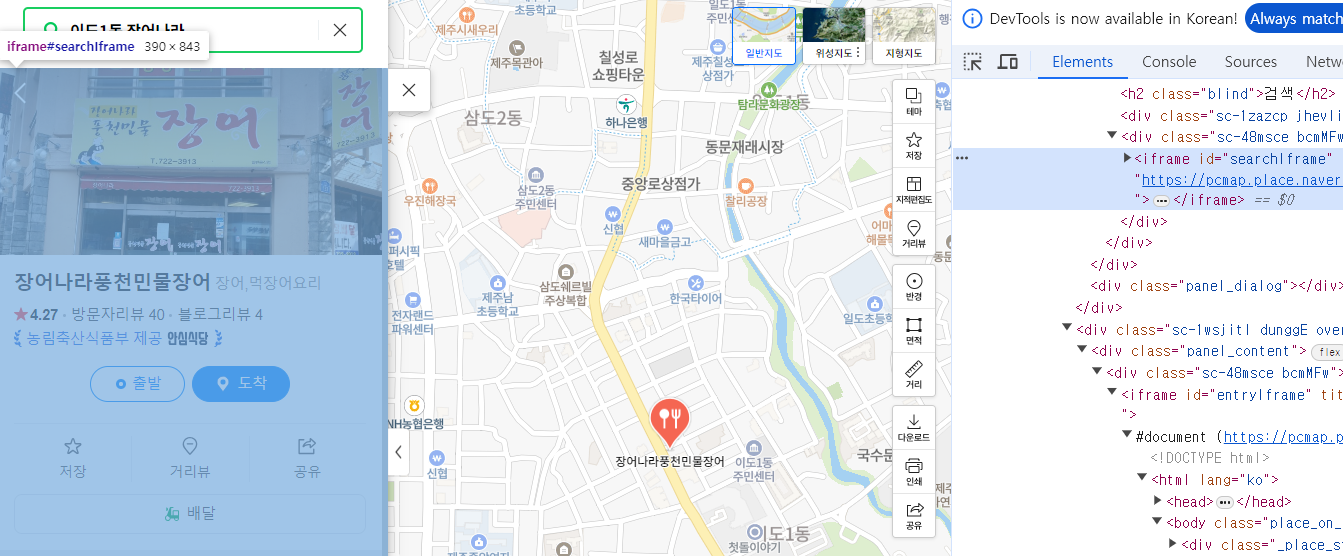

* 이미지 크롤링
    * 장어나라풍천민물장어 문구 위에 대표이미지를 크롤링하자

In [22]:
soup = BeautifulSoup(driver.page_source, 'html.parser')

In [23]:
found = soup.find("div", class_="lazyload-wrapper").img
img_url = found['src']
img_url

'https://search.pstatic.net/common/?autoRotate=true&quality=95&type=f160_160&src=https%3A%2F%2Fldb-phinf.pstatic.net%2F20210102_41%2F1609560084900MxMi3_JPEG%2Fimage.jpg'

In [24]:
shop_id = 'MA010120220805430915' # 기준데이터에서 해당 상가의 ID를 기준으로 이름을 정한다.
save_file_name = f'img\\{shop_id}.jpg'

In [25]:
img_data = requests.get(img_url).content
with open(save_file_name, "wb") as img_file:
    img_file.write(img_data)

FileNotFoundError: [Errno 2] No such file or directory: 'img\\MA010120220805430915.jpg'

In [13]:
!dir img\*.jpg

지정된 파일을 찾을 수 없습니다.


# 평점정보

* 평점 정보는 html 요소에 있지 않고 자바스크립트 코드에 있으므로 정규식을 활용한다.

In [17]:
import re

* 매치가 되지 않을 경우 예외처리

In [20]:
visitor_review_score = re.search(r'"visitorReviewScore":"(\d+\.\d+)"', driver.page_source)

In [ ]:
visitor_review_score.group(1) # 현재 정책으로 인하여 기존에 제공했던 평점 정보를 제공하고 있지 않아 예외발생

AttributeError: 'NoneType' object has no attribute 'group'

In [24]:
if visitor_review_score:
    visitor_review_score = match.group(1)
else:
    visitor_review_score = None 

print(visitor_review_score)

None


# 방문자리뷰 카운트

In [18]:
visitor_review_count = re.search(r'"visitorReviewCount":"(\d+)"', driver.page_source)
visitor_review_count.group(1)

'46'

# 블로그리뷰 카운트

In [19]:
blog_review_count = re.search(r'"blogCafeReviewCount":"(\d+)"', driver.page_source)
blog_review_count.group(1)

'4'